In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import librosa
import librosa.display
import IPython.display as ipd
import tensorflow as tf
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

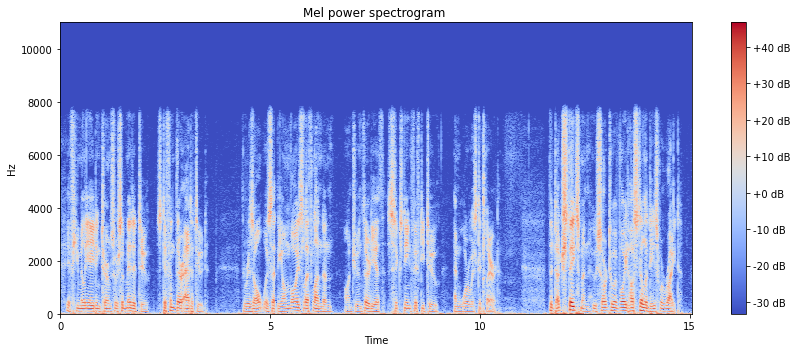

In [3]:
audio_data = '../vad_data/1081-125237-0033.wav' #'recorded.wav'
signal , sr = librosa.load(audio_data)
start = 0
end = len(signal)//sr
seg_star = int(np.floor(start * sr))
seg_end = int(np.floor(end * sr))
ipd.Audio(data=signal[seg_star:seg_end], rate=sr)


X = librosa.stft(signal.astype('float'))
Xdb = librosa.amplitude_to_db(X)
plt.figure(figsize=(12, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [4]:
def extract_features(signal, sr=16000, n_mfcc=5, size=512, step=16, n_mels=40):
    mfcc = librosa.feature.mfcc(signal, sr=sr, n_mfcc=n_mfcc, n_fft=size, hop_length=step)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)

    mel_spectogram = librosa.feature.melspectrogram(signal, sr=sr, n_mels=n_mels, n_fft=size, hop_length=step)
    rmse = librosa.feature.rms(S=mel_spectogram, frame_length=n_mels * 2 - 1, hop_length=step)

    mfcc, mfcc_delta, mfcc_delta_2, rmse = np.asarray(mfcc), np.asarray(mfcc_delta), np.asarray(mfcc_delta_2), np.asarray(rmse)
    # print(mfcc.shape, mfcc_delta.shape, mfcc_delta_2.shape, rmse.shape)
    features = np.concatenate((mfcc, mfcc_delta, mfcc_delta_2, rmse), axis=0)
    return features.transpose()

nbseg = (seg_end - seg_star)//1024
print(nbseg)
data = []
start = seg_star
end = start + 1024
segs = []
for seg in range(nbseg):
    segs.append([start, end])
    data.append(extract_features(signal[start:end]))
    start += 1024
    end += 1024
data = np.asarray(data)
data.shape

322


(322, 65, 16)

In [5]:
import tensorflow as tf
# import keras_resnet.models

# model = tf.keras.models.load_model('tuan.h5')
# model.summary()

shape, classes = (65, 16, 1), 2
# x = tf.keras.layers.Input(shape)
# model = keras_resnet.models.ResNet18(x, classes=classes)
# model.load_weights('lstm.h5')
model = tf.keras.models.load_model('../models/cnn.h5')

2022-02-09 23:29:49.881082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-09 23:29:49.881894: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [6]:
predict = model.predict(data.reshape(data.shape[0], 65, 16, 1))
# predict = model.predict(data)
predict = np.argmax(predict, axis=1)
print(predict)

2022-02-09 23:29:50.316840: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-09 23:29:50.393317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]


In [7]:
label_train = np.load('../data_train_test/train_labels.npy')
label_test = np.load('../data_train_test/test_labels.npy')

print(len(label_train))
print(len(label_test))
print(label_train.sum())
print(label_test.sum())

131118
32950
106082
26721


In [8]:
# ratio of speech / total
(106082+26721)/(131118+32950)

0.8094387692907818

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

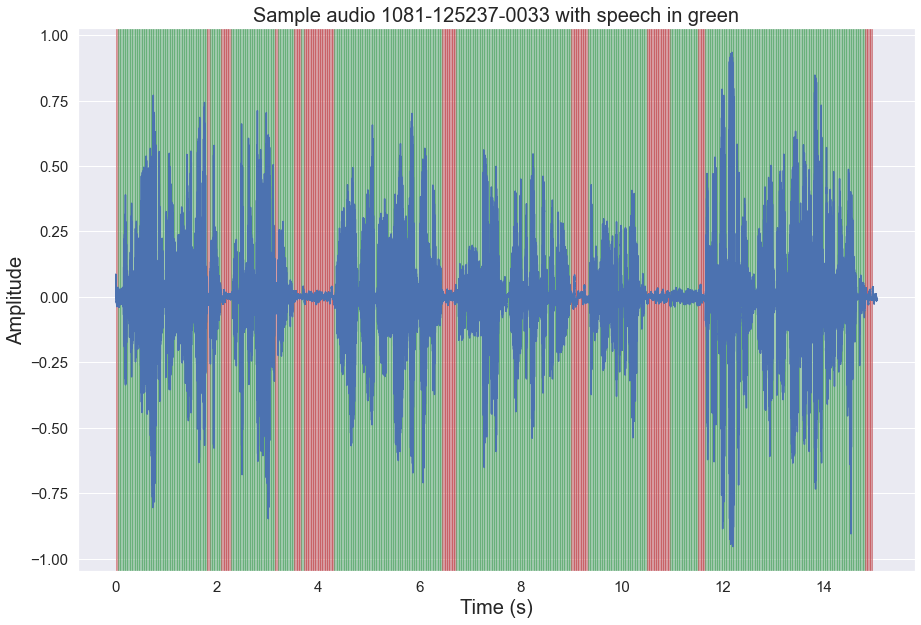

In [10]:
plt.figure(figsize=(15, 10))
sns.set()
sns.lineplot(x=[i / sr for i in range(len(signal))], y=signal)

start, end = 0, 0
for i, seg in enumerate(segs):
    start, end = seg[0] / sr, seg[1] / sr
    color = 'r' if predict[i]==0 else 'g'
    plt.axvspan(start, end, alpha=0.5, color=color)

plt.title(f"Sample audio 1081-125237-0033 with speech in green", size=20)
plt.xlabel("Time (s)", size=20)
plt.ylabel("Amplitude", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig('sample.png', dpi=300)
plt.show()

# Draw train accuracy, train loss 

In [11]:
cnn_acc = np.loadtxt('../logs/cnn_acc.txt')
lstm_acc = np.loadtxt('../logs/lstm_acc.txt')
fully_acc = np.loadtxt('../logs/fully_acc.txt')
resnet_acc = np.loadtxt('../logs/resnet_acc.txt')
x = range(0, 50)

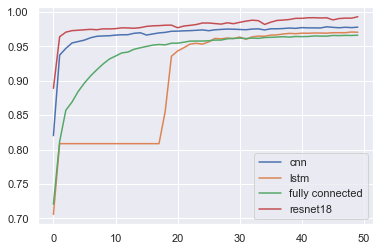

In [12]:
plt.plot(x, cnn_acc, label= "cnn")
plt.plot(x, lstm_acc, label= "lstm")
plt.plot(x, fully_acc, label= "fully connected")
plt.plot(x, resnet_acc, label= "resnet18")
plt.legend()
plt.savefig('train_accuracy.png', dpi=300)
plt.show()

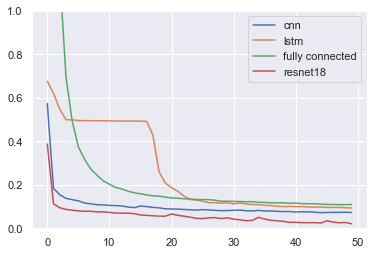

In [13]:
cnn_loss = np.loadtxt('../logs/cnn_loss.txt')
lstm_loss = np.loadtxt('../logs/lstm_loss.txt')
fully_loss = np.loadtxt('../logs/fully_loss.txt')
resnet_loss = np.loadtxt('../logs/resnet_loss.txt')
x = range(0, 50)

plt.plot(x, cnn_loss, label= "cnn")
plt.plot(x, lstm_loss, label= "lstm")
plt.plot(x, fully_loss, label= "fully connected")
plt.plot(x, resnet_loss, label= "resnet18")
plt.legend()
plt.ylim(0, 1)
plt.savefig('train_loss.png', dpi=300)
plt.show()